In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
"""
Genera i dati necessari per il problema.
    
Args:
    m (int): Numero di misurazioni.
    d (int): Dimensione del vettore del segnale.
    
Returns:
    X (ndarray): Matrice delle misurazioni di dimensione (m, d).
    y (ndarray): Vettore delle misurazioni di dimensione (m, ).
    theta (ndarray): Vettore del segnale binario di dimensione (d, ).
"""
def generate_data(m, d):
    X = np.random.normal(0, 1, (m, d))  # Genera la matrice X con distribuzione normale standard
    theta = np.random.choice([0, 1], d)  # Genera il vettore del segnale theta con valori binari
    xi = np.random.normal(0, 1, m)  # Genera il vettore del rumore xi
    y = X @ theta + xi  # Calcola il vettore delle misurazioni y
    return X, y, theta

$$ 𝑦 = 𝑋𝜃 + 𝜉 $$

In [4]:
"""
Calcola la funzione di verosimiglianza negativa.
    
Args:
    X (ndarray): Matrice delle misurazioni.
    y (ndarray): Vettore delle misurazioni.
    theta (ndarray): Vettore del segnale binario.
    
Returns:
    float: Valore della funzione di verosimiglianza negativa.
"""
def H(X, y, theta):
    return (y - X @ theta).T @ (y - X @ theta) # Norma al quadrato della differenza tra y e Xθ

$$ \mathcal{H}(X, y; \theta) = (y - X\theta)^T (y - X\theta) $$

$$ \text{L'obiettivo dell'algoritmo di Metropolis-Hastings è trovare il valore del vettore } ( \theta ) \text{ che minimizza } ( H(X, y; \theta) ) $$


In [5]:
"""
Implementa l'algoritmo di Metropolis-Hastings per stimare il vettore del segnale theta.
Args:
    X (ndarray): Matrice delle misurazioni.
    y (ndarray): Vettore delle misurazioni.
    beta (float): Parametro di controllo per l'algoritmo.
    N (int): Numero di iterazioni dell'algoritmo.
    theta_init (ndarray): Vettore iniziale del segnale.
Returns:
        ndarray: Vettore stimato del segnale theta.
"""   
def metropolis_hastings(X, y, beta, N, theta_init): 
    d = theta_init.shape[0]
    theta = theta_init.copy()
    for t in range(N):
        i = np.random.randint(d)  #Seleziona un indice 𝑖 casuale tra 0 e 𝑑-1
        theta_proposal = theta.copy()
        theta_proposal[i] = 1 - theta_proposal[i]  #Proposta di nuovi stati, cambiando quello corrente
        # Cambiare un valore per iterazione
        H_current = H(X, y, theta)  #Calcola H per lo stato corrente
        H_proposal = H(X, y, theta_proposal)  #Calcola H per lo stato proposto
        acceptance_ratio = min(1, np.exp(-beta * (H_proposal - H_current)))  #Calcola il rapporto di accettazione
        #Se lo stato proposto ha un valore di 𝐻 più basso (verosomiglianza più alta), è più probabile che venga accettato.
        if np.random.rand() < acceptance_ratio:
            theta = theta_proposal  # Accetta la proposta

    return theta

$$
\pi_{\beta}(\theta) = \frac{e^{-\beta \mathcal{H}(X;y;\theta)}}{Z_{\beta}}, \quad \text{with} \quad Z_{\beta} = \sum_{\theta \in \Theta} e^{-\beta H(X;y;\theta)}
$$


In [6]:
"""
Calcola l'errore quadratico medio (MSE) tra il vettore del segnale vero e quello stimato.
    
Args:
    theta_true (ndarray): Vettore del segnale vero.
    theta_est (ndarray): Vettore del segnale stimato.
    
Returns:
    float: Valore dell'errore quadratico medio.
"""
def mean_squared_error(theta_true, theta_est):
    return np.mean((theta_true - theta_est)**2)

$$
E = \mathbb{E}\left[ (\hat{\theta} - \theta)^T (\hat{\theta} - \theta) \right]
\text{to check the quality of our estimate}
$$


In [7]:
d = 10  # Dimensione del vettore del segnale
ms = range(1, 16)  # Diversi valori di m (numero di misurazioni)
beta = 1.0  # Parametro di controllo per l'algoritmo Metropolis-Hastings
N = 100  # Numero di iterazioni dell'algoritmo
M = 1000  # Numero di realizzazioni indipendenti

In [8]:
mse_values = []  # Lista per memorizzare i valori dell'MSE

# Calcolo dell'MSE per diversi valori di m
for m in ms:
    errors = []
    for _ in range(M):
        X, y, theta_true = generate_data(m, d)  # Genera i dati, theta true è quello che sto cercando
        theta_init = np.random.randint(0, 2, d)  # Inizializza casualmente theta
        theta_est = metropolis_hastings(X, y, beta, N, theta_init)  # Stima theta usando Metropolis-Hastings
        error = mean_squared_error(theta_true, theta_est)  # Calcola l'errore quadratico medio
        errors.append(error) #ho un array di mille errori

    mse = np.mean(errors)  # Calcola la media degli errori per il valore corrente di m
    mse_values.append(mse)

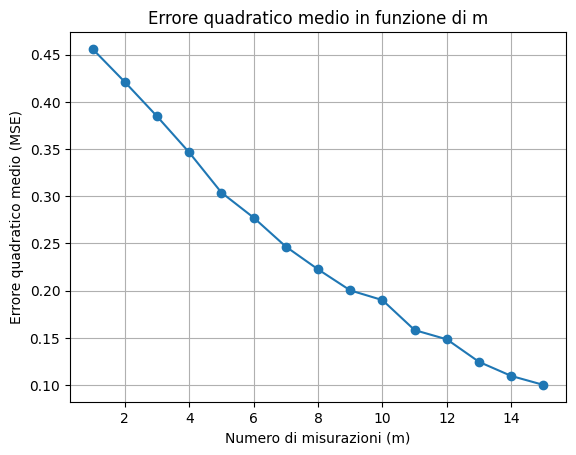

In [9]:
# Plot dei risultati
plt.plot(ms, mse_values, marker='o')
plt.xlabel('Numero di misurazioni (m)')
plt.ylabel('Errore quadratico medio (MSE)')
plt.title('Errore quadratico medio in funzione di m')
plt.grid(True)
plt.show()

In [10]:
# Determinare il valore minimo di m per cui l'MSE è sufficientemente basso
threshold_mse = 0.1  # Soglia arbitraria per considerare la stima affidabile
reliable_m_indices = [i for i, mse in enumerate(mse_values) if mse < threshold_mse]

if reliable_m_indices:
    min_m = ms[reliable_m_indices[0]]
    print(f"Valore minimo di m/d per recuperare theta in modo affidabile: {min_m/d:.2f}")
else:
    print("Non è stato trovato un valore di m per cui l'MSE è inferiore alla soglia.")

Non è stato trovato un valore di m per cui l'MSE è inferiore alla soglia.
